# `naturf` Quickstarter

The Neighborhood Adaptive Tissues for Urban Resilience Futures tool (`naturf`) is a Python workflow that generates files readable by the Weather Research and Forecasting (WRF) model. `naturf` uses *geopandas* and *hamilton* to calculate 132 building parameters from shapefiles with building footprint and height information. These parameters can be collected and used in many formats, and the primary output is a binary file configured for input to WRF. This workflow is a flexible adaptation of the National/World Urban Database and Access Portal Tool (NUDAPT/WUDAPT) that can be used with any study area at any spatial resolution. The climate modeling community and urban planners can identify the effects of building/neighborhood morphology on the microclimate using the urban parameters and WRF-readable files produced by `naturf`. The source code for `naturf` can be found on [GitHub](https://github.com/IMMM-SFA/naturf/tree/main), and more information on the urban parameters calculated can be found in the [documentation](https://immm-sfa.github.io/naturf/). Cases 1 and 2 below illustrate using *hamilton* to pull different outputs from `naturf` using example data. Case 3 shows how to use `naturf` with user data.

In [1]:
from hamilton import telemetry
from importlib.resources import files
from naturf import driver

## Case 1

`naturf` requires two inputs: an input dictionary with the location of the input buildings shapefile, and a list of the desired outputs. For this first case, we can look at three outputs: `plan_area_fraction`, `area_weighted_mean_of_building_heights`, and `sky_view_factor`.

In [2]:
input_shapefile_path = str(files("naturf.data").joinpath("C-5.shp"))

inputs = {
    "input_shapefile": input_shapefile_path,
}

outputs = [
    "plan_area_fraction",
    "area_weighted_mean_of_building_heights",
    "sky_view_factor"
    ]

# Disable Hamilton anonymous user data tracking
telemetry.disable_telemetry()

model = driver.Model(inputs, outputs)

Render the Directed Acyclic Graph (DAG) to show which functions the model calls in order to create the desired output. Note that the model doesn't execute!

Note: you will need [graphviz](https://graphviz.org/download/) to visualize the Directed Acyclic Graph (DAG)

```pip install graphviz```

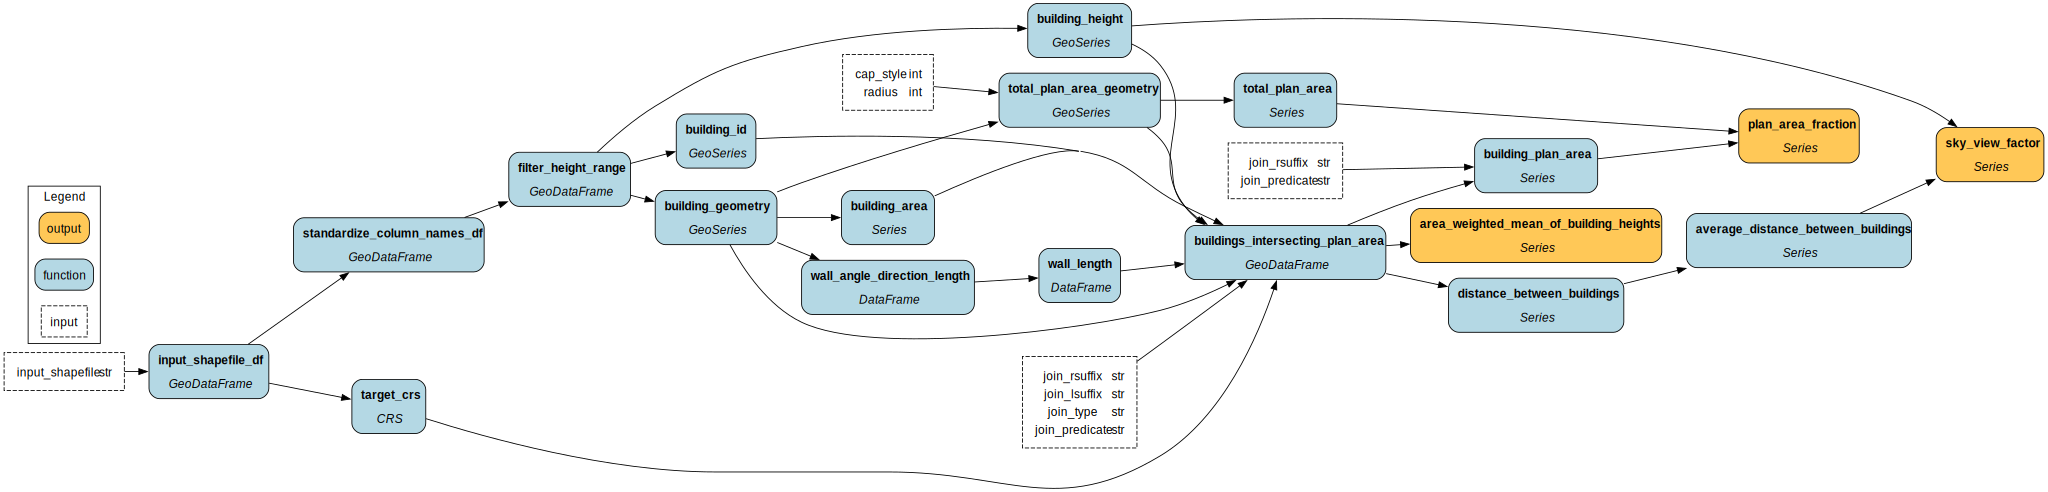

In [3]:
model.graph()

Execute the model.

In [4]:
df = model.execute()

Naturf DAG -> Execution Complete!                   : 100%|██████████████| 19/19 [00:08<00:00,  2.29funcs/s]


View the first three rows of the output dataframe. Note that `naturf` only outputs the desired columns, as specified above.

In [5]:
df.head(3)

,plan_area_fraction,area_weighted_mean_of_building_heights,sky_view_factor
0,0.009073,2.660000,0.168611
1,0.010528,2.660000,0.168611
2,0.128917,20.193242,0.730937


## Case 2: Full Model Run

Here we run the full model in order to get the required inputs to WRF. WRF requires two files: a binary file with the urban parameter data gridded and written row-by-row into binary and an index file that tells WRF where to put and how to display the data. See the [WRF User Guide](https://homepages.see.leeds.ac.uk/~lecrrb/wrf/aRWUsersGuide.pdf) for more information. The nodes `write_binary` and `write_index` will write the required files to the working directory.

We include `merge_parameters` here to better demonstrate the output DataFrame, if you don't include it in the run, the output DataFrame shows only `write_binary` and `write_index`. This is great when you're running the model to create outputs for WRF, but not great for visualizing the output parameters. 

In [6]:
outputs = [
    "merge_parameters",
    "write_binary", 
    "write_index",
    ]

model = driver.Model(inputs, outputs)

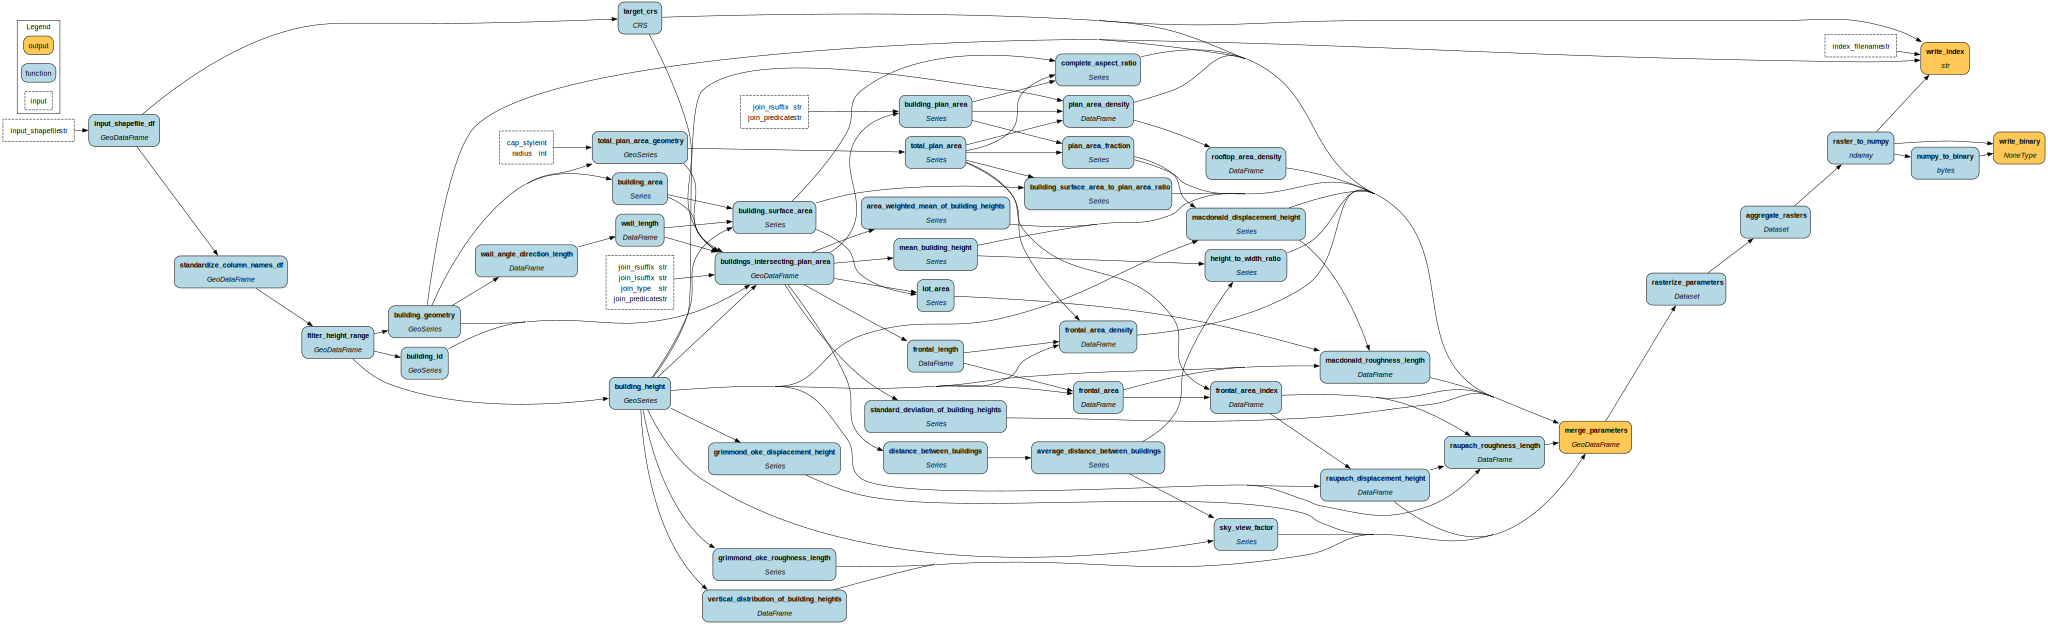

In [7]:
model.graph()

In [8]:
df = model.execute()

Naturf DAG -> Execution Complete!                      : 100%|███████████| 46/46 [00:13<00:00,  3.44funcs/s]


In [9]:
df.head()

,merge_parameters.frontal_area_north_0,merge_parameters.frontal_area_north_1,merge_parameters.frontal_area_north_2,merge_parameters.frontal_area_north_3,merge_parameters.frontal_area_north_4,merge_parameters.frontal_area_north_5,merge_parameters.frontal_area_north_6,merge_parameters.frontal_area_north_7,merge_parameters.frontal_area_north_8,merge_parameters.frontal_area_north_9,...,merge_parameters.vertical_distribution_of_building_heights_9,merge_parameters.vertical_distribution_of_building_heights_10,merge_parameters.vertical_distribution_of_building_heights_11,merge_parameters.vertical_distribution_of_building_heights_12,merge_parameters.vertical_distribution_of_building_heights_13,merge_parameters.vertical_distribution_of_building_heights_14,merge_parameters.building_geometry,merge_parameters.building_count,write_binary,write_index
0,0.001903,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0,...,0,0,0,0,0,0,"POLYGON ((-77.04892 38.87526, -77.04893 38.875...",1,None,None
1,0.002208,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0,...,0,0,0,0,0,0,"POLYGON ((-77.04882 38.87532, -77.04884 38.875...",1,None,None
2,0.019133,0.019133,0.019133,0.019133,0.019133,0.001569,0.0,0.0,0,0,...,0,0,0,0,0,0,"POLYGON ((-77.02035 38.87679, -77.02036 38.876...",1,None,None
3,0.023445,0.023445,0.009331,0.000000,0.000000,0.000000,0.0,0.0,0,0,...,0,0,0,0,0,0,"POLYGON ((-77.02585 38.87985, -77.02589 38.879...",1,None,None
4,0.036085,0.036085,0.018620,0.000000,0.000000,0.000000,0.0,0.0,0,0,...,0,0,0,0,0,0,"POLYGON ((-77.02369 38.87912, -77.02309 38.878...",1,None,None


We have 136 columns here, which are the 132 output parameters plus 4 other parameters: `merge_parameters.building_geometry`, `merge_parameters.building_count`, `write_binary`, and `write_index`. The first two are used for calculations in the model but are not output parameters, and the last two are the nodes that are called to output the required WRF files. 

## Case 3

If the user has their own shapefile to process, the config values and input path must be changed to reflect that data. The only config values that require changes are `DATA_ID_FIELD_NAME` and `DATA_HEIGHT_FIELD_NAME`. Config values can be changed by importing the `Settings` class from `naturf.config`. NOTE: Shapefiles input to `naturf` need to be in a projected coordinate system such as Albers Equal Area Conic. 

In [ ]:
# from naturf.config import Settings

# Settings.DATA_ID_FIELD_NAME = "YOUR_ID_FIELD_NAME_HERE"
# Settings.DATA_HEIGHT_FIELD_NAME = "YOUR_HEIGHT_FIELD_NAME_HERE"

# input_shapefile_path = "PATH_TO_YOUR_DATA"

From here, the normal workflow can be continued.

In [ ]:
# inputs = {"input_shapefile": input_shapefile_path}
# outputs = ["DESIRED_PARAMETERS_HERE"]
# model = driver.Model(inputs, outputs)

# df = model.execute()

Currently, `naturf` does not have a function to convert the calculated parameters to any files other than the binary file to be given to WRF. However, this can be achieved using the `df` variable created when executing the model. For example, if we want to write all of the calculated parameters for each building with the building IDs to a CSV file, all we need to do is set the `outputs` to `["building_ids", "merge_parameters"]` and write the `df` variable to a CSV.

In [ ]:
# outputs = ["building_id", "merge_parameters"]
# model = driver.Model(inputs, outputs)

# df = model.execute()
# df.to_csv("outfile.csv")

## Optional: DAGWorks Interactive Dashboard

Since we're using `hamilton` to run `naturf`, users can log each run to DAGWorks (researchers/academics have access to the free tier) by signing up at [dagworks.io](www.dagworks.io) and creating a project. Then either set the environment variables `DAGWORKS_API_KEY`, `DAGWORKS_USERNAME`, and `DAGWORKS_PROJECT_ID` below or set it in the module directly.

In [ ]:
# driver.DAGWORKS_API_KEY = "your_api_key"
# driver.DAGWORKS_USERNAME = "your_username"
# driver.DAGWORKS_PROJECT_ID = "your_project_id"  # some integer.

# model = driver.Model(inputs, ["input_shapefile_df"])
# model.execute()